# Surrogate Construction for Genz Functions as a function of PC order

This notebook constructs a PC surrogate for Genz functions using Galerkin projection (full and sparse quadrature) and regression. It also calculates the RMS error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
max_nord = 6        # Order of the PCE
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 10000       # Number of random samples
ndim = 5           # Number of dimensions
model= 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'  

First, we define the random number generator and the range of orders that we will be calculating over.

In [3]:
tot_ord=range(1, 1+max_nord)
np.random.seed(42)
rng = np.random.default_rng()

## Regression
We loop through different PC orders, calculating the coefficients with regression and obtaining the RMSE for each. We use 110% of the number of basis terms for sample points.

In [4]:
errors1=[] # list to store errors
std=[]
# loop through different PC orders
for nord in tot_ord:
    RMSE_list=[]
    for i in range(10):
        # Instantiate model
        pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim,pc_type, pc_alpha,pc_beta)

        # Training points
        npce=pc_model.GetNumberPCTerms()
        nTest=int(npce*1.1)
        #rand=np.random.normal(loc=0, scale=0.5, size=(nTest, ndim))
        rand=2*rng.random((int(nTest*1.1), ndim))-1
        f_evals=func(rand, model, np.ones(ndim+1))

        # Coefficients
        c_k=pce_tools.UQTkRegression(pc_model, f_evals, rand)

        # Testing points
        #germ_samples=np.random.normal(0,1, (nSam,ndim))
        germ_samples=2*rng.random((nSam, ndim))-1
        pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
        f_actual=func(germ_samples,model,np.ones(ndim+1))

        # Error
        MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
        RMSE=math.sqrt(MSE)
        RMSE_list.append(RMSE)
    errors1.append(np.array(RMSE_list).mean())
    std.append(np.std(np.array(RMSE_list)))

## Galerkin Projection and Full Quadrature
We loop through different PC orders for full quadrature and obtain the RMSE for each.

In [5]:
errors2=[] #list to store errors

#Loop though different PC orders
for nord in tot_ord:
    
    # Instantiate PC object
    pc_model2 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
    
    # Training points (full quadrature)
    param = nord +1 # Number of quad points per dimension
    pc_model2.SetQuadRule(pc_type, 'full', param)
    qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model2)
    f_evals2=func(qdpts,model,np.ones(ndim+1))
    
    # Coefficients
    c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,f_evals2)
    
    # Testing Points
    #germ_samples2=np.random.normal(0,1, (nSam,ndim))
    germ_samples2=2*rng.random((nSam, ndim))-1
    pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)
    f_actual2=func(germ_samples2,model,np.ones(ndim+1))
    
    # Error
    MSE2 = np.square(np.subtract(f_actual2,pce_evals2)).mean()
    RMSE2=math.sqrt(MSE2)
    errors2.append(RMSE2)

## Galerkin Projection and Sparse Quadrature
We loop through different PC orders for sparse quadrature and obtain the RMSE for each.

In [6]:
errors3=[] #list to store quad errors

#Loop though different values for PC order
for nord in tot_ord:
    
    # Instantiate PC object
    pc_model3 = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
    
    # Training points (sparse quadrature)
    param = nord + 1 # Level of quadrature
    pc_model3.SetQuadRule(pc_type, 'sparse', param)
    qdpts3, totquat3= pce_tools.UQTkGetQuadPoints(pc_model3)
    f_evals3=func(qdpts3, model, np.ones(ndim+1))
    
    # Coefficients
    c_k3 = pce_tools.UQTkGalerkinProjection(pc_model3,f_evals3)
    
    # Testing Points
    #germ_samples3=np.random.normal(0,1, (nSam,ndim))
    germ_samples3=2*rng.random((nSam, ndim))-1
    pce_evals3=pce_tools.UQTkEvaluatePCE(pc_model3,c_k3,germ_samples3)
    f_actual3=func(germ_samples3,model,np.ones(ndim+1))
    
    # Error
    MSE3 = np.square(np.subtract(f_actual3,pce_evals3)).mean()
    RMSE3=math.sqrt(MSE3)
    errors3.append(RMSE3)

## Summary
The following table and figures compare full and sparse quadrature RMSEs as a function of the PC order.

In [7]:
pd.DataFrame(data=np.transpose([tot_ord, errors1, errors2, errors3]), columns=["nord", "Regression", "Full", "Sparse"])

,nord,Regression,Full,Sparse
0,1.0,0.464725,0.196839,0.194836
1,2.0,0.104067,0.048749,0.048089
2,3.0,0.041309,0.015943,0.018292
3,4.0,0.008117,0.002850,0.002559
4,5.0,0.001630,0.000663,0.000602
5,6.0,0.000260,0.000073,0.000075


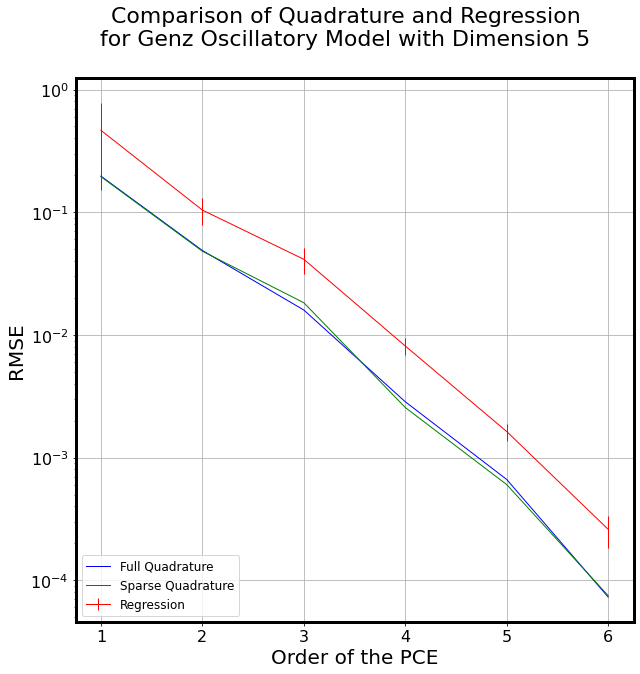

In [8]:
#Create figure
fig, ax = plt.subplots(figsize=(10,10))
#Plot Quadrature Data
plt.errorbar(tot_ord, errors1, color='r', yerr=std, xerr=None, label='Regression')
plt.plot(tot_ord, errors2, color='b', label='Full Quadrature')
plt.plot(tot_ord, errors3, color='g', label='Sparse Quadrature')
#Label Axes
plt.xlabel("Order of the PCE",fontsize=20)
plt.ylabel("RMSE",fontsize=20)
#Create legend
plt.legend(loc='lower left')

#Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

#Add title
fig.suptitle("Comparison of Quadrature and Regression\nfor %s Model with\
 Dimension %s"%(model_title, str(ndim)), fontsize=22)
#Make y scale logarithmic
plt.yscale('log')
#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 